### Black Box Attacks and Defenses 

### Experiment 3

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models 

import numpy as np

from art.estimators.classification import PyTorchClassifier

from PIL import Image
from torchvision import transforms

In [2]:
import ast 
import pandas as pd 

In [3]:
import matplotlib.pyplot as plt 

from datetime import datetime ## important 
import time 
import warnings
warnings.filterwarnings('ignore')

In [4]:
from model_codes_cifar100.vgg_cifar100 import * 
from model_codes_cifar100.resnet_cifar100 import * 
from model_codes_cifar100.densenet_cifar100 import * 

In [5]:
import torch
torch.cuda.set_device(2)
torch.cuda.current_device()

device_name = 'cuda:2'

#### Attacks from ART 

In [6]:
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import NewtonFool 
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import SimBA
from art.attacks.evasion import HopSkipJump

In [7]:
from skimage.metrics import structural_similarity as ssim

#### Some methods and variables 

In [8]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [9]:
def softmax_activation(inputs): 
    inputs = inputs.tolist()
    exp_values = np.exp(inputs - np.max(inputs)) 
    
    # Normalize 
    probabilities = exp_values / np.sum(exp_values)
    return probabilities

In [10]:
def compare_images(imageA, imageB):
    return 1 - ssim(imageA, imageB, multichannel=True)

In [11]:
def calc_L_dist(adv_map, targ_map):
    n = len(adv_map)
    l1_dist = np.linalg.norm(adv_map.reshape((n, -1)) - targ_map.reshape((n, -1)), 1, axis=1) 
    
    l1_dist = l1_dist[0]/(32*32)
    return l1_dist

In [12]:
# CIFAR 10 selected images dataset 
# selected_images_file_path = "data/exp3_1000_cifar100_images_paths_filter65.txt"
selected_images_file_path = "data/200_cifar100_images_paths_filter65.txt"

#### Loading images selected image paths 

In [13]:
selected_images_list_file = open(selected_images_file_path, "r")
loaded_image_paths_list = selected_images_list_file.read()

### Converst file content into list using ast
loaded_image_paths_list = ast.literal_eval(loaded_image_paths_list)

In [14]:
len(loaded_image_paths_list)

200

In [15]:
loaded_image_paths_list[0]

'cifar100png/test/wardrobe/0041.png'

### Main method

In [16]:
def experiment3_method(target_classifier, attack, image_list): 
    column_list = ['image', 'benign_pred', 'benign_conf', 'adv_pred', 'adv_conf', 'attack_time', 'noise_ratio'] 
    results_df =  pd.DataFrame(columns = column_list) 
    
    for image in image_list: 
        input_image = Image.open(image)
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0).numpy().astype(np.float32)
        
        preds = target_classifier.predict(input_batch)  
        predicted_label = np.argmax(preds, axis=1)[0] 
        
        confidence = round(np.max(softmax_activation(preds), axis=1)[0], 3) 
        
        ## attack 
        start = time.time() 
        adv_image = attack.generate(x=input_batch)
        attack_time = time.time()-start 
        
        noise_ratio = compare_images(input_batch[0].transpose(1,2,0), adv_image[0].transpose(1,2,0))
        noise_ratio = round(noise_ratio, 5) 
        
        l1_distance = calc_L_dist(adv_image, input_batch)
        
        adv_prediction = target_classifier.predict(adv_image)  
        adv_predicted_label = np.argmax(adv_prediction, axis=1)[0] 
        adv_confidence = round(np.max(softmax_activation(adv_prediction), axis=1)[0], 3)  
        
        results_df = results_df.append({'image': image, 
                                       'benign_pred': predicted_label, 
                                       'benign_conf': confidence, 
                                       'adv_pred': adv_predicted_label,
                                       'adv_conf': adv_confidence, 
                                       'attack_time': attack_time, 
                                       'noise_ratio': noise_ratio, 
                                       'l1_distance': l1_distance}, ignore_index=True)
    return results_df

In [17]:
def summarize_result(results, total_images):
    avg_benign_conf = round(results['benign_conf'].mean(), 3)
    benign_conf_std = round(results['benign_conf'].std(), 3)
    
    attack_success_count = results[results.benign_pred != results.adv_pred]["image"].count()
    attack_failure_count = total_images - attack_success_count 
    
    avg_adv_success_conf = round(results[results.benign_pred != results.adv_pred]["adv_conf"].mean(), 3) 
    adv_success_conf_std = round(results[results.benign_pred != results.adv_pred]["adv_conf"].std(), 3) 
    
    avg_adv_fail_conf = round(results[results.benign_pred == results.adv_pred]["adv_conf"].mean(), 3) 
    adv_fail_conf_std = round(results[results.benign_pred == results.adv_pred]["adv_conf"].std(), 3) 
    
    avg_attack_time = round(results['attack_time'].mean(), 4) 
    attack_time_std = round(results['attack_time'].std(), 4) 
    
    avg_noise_ratio = round(results['noise_ratio'].mean(), 5) 
    noise_ratio_std = round(results['noise_ratio'].std(), 5)
    
    avg_l1_distance = round(results['l1_distance'].mean(), 5)      
    l1_distance_std = round(results['l1_distance'].std(), 5)  
    
    
    print("Benign average confidence: {} ± {}".format(avg_benign_conf, benign_conf_std))
    print("Attack success rate: {}/1K ({}±{})".format(attack_success_count, avg_adv_success_conf, adv_success_conf_std))
    print("Attack failure rate: {}/1K ({}±{})".format(attack_failure_count, avg_adv_fail_conf, adv_fail_conf_std))
    print("Average attack time: {} ± {}".format(avg_attack_time, attack_time_std))
    print("Average noise ratio: {} ± {}".format(avg_noise_ratio, noise_ratio_std))    
    print("Average l1 distance: {} ± {}".format(avg_l1_distance, l1_distance_std))  
    print("===================================")

In [18]:
model_resnet18 = resnet18() 
model_resnet34 = resnet34()
model_resnet50 = resnet50()
model_resnet101 = resnet101()
model_resnet152 = resnet152() 

model_vgg11 = VGG('VGG11')
model_vgg13 = VGG('VGG13')
model_vgg16 = VGG('VGG16')
model_vgg19 = VGG('VGG19')

model_densenet121 = densenet121() 
model_densenet161 = densenet161() 
model_densenet169 = densenet169() 
model_densenet201 = densenet201() 

resnet18_file_name = "trained_models_cifar100/resnet18_cifar100.pth"  
resnet34_file_name = "trained_models_cifar100/resnet34_cifar100.pth"  
resnet50_file_name = "trained_models_cifar100/resnet50_cifar100.pth"  
resnet101_file_name = "trained_models_cifar100/resnet101_cifar100.pth"  
resnet152_file_name = "trained_models_cifar100/resnet152_cifar100.pth"  

vgg11_file_name = "trained_models_cifar100/vgg11_cifar100.pth"  
vgg13_file_name = "trained_models_cifar100/vgg13_cifar100.pth"  
vgg16_file_name = "trained_models_cifar100/vgg16_cifar100.pth"  
vgg19_file_name = "trained_models_cifar100/vgg19_cifar100.pth"  

densenet121_file_name = "trained_models_cifar100/densenet121_cifar100.pth"  
densenet161_file_name = "trained_models_cifar100/densenet161_cifar100.pth"  
densenet169_file_name = "trained_models_cifar100/densenet169_cifar100.pth"  
densenet201_file_name = "trained_models_cifar100/densenet201_cifar100.pth"  

model_resnet18.load_state_dict(torch.load(resnet18_file_name, map_location=device_name)['net'])
model_resnet34.load_state_dict(torch.load(resnet34_file_name, map_location=device_name)['net'])
model_resnet50.load_state_dict(torch.load(resnet50_file_name, map_location=device_name)['net'])
model_resnet101.load_state_dict(torch.load(resnet101_file_name, map_location=device_name)['net'])
model_resnet152.load_state_dict(torch.load(resnet152_file_name, map_location=device_name)['net'])

model_vgg11.load_state_dict(torch.load(vgg11_file_name, map_location=device_name)['net'])
model_vgg13.load_state_dict(torch.load(vgg13_file_name, map_location=device_name)['net'])
model_vgg16.load_state_dict(torch.load(vgg16_file_name, map_location=device_name)['net'])
model_vgg19.load_state_dict(torch.load(vgg19_file_name, map_location=device_name)['net'])

model_densenet121.load_state_dict(torch.load(densenet121_file_name, map_location=device_name)['net'])
model_densenet161.load_state_dict(torch.load(densenet161_file_name, map_location=device_name)['net'])
model_densenet169.load_state_dict(torch.load(densenet169_file_name, map_location=device_name)['net'])
model_densenet201.load_state_dict(torch.load(densenet201_file_name, map_location=device_name)['net'])

model_resnet18.eval()
model_resnet34.eval()
model_resnet50.eval()
model_resnet101.eval()
model_resnet152.eval()

model_vgg11.eval()
model_vgg13.eval()
model_vgg16.eval()
model_vgg19.eval()

model_densenet121.eval()
model_densenet161.eval()
model_densenet169.eval()
model_densenet201.eval()

print("Done")

Done


In [19]:
target_models_list = [model_resnet18, model_resnet34, model_resnet50, model_resnet101, model_resnet152, 
                      model_vgg11, model_vgg13, model_vgg16, model_vgg19,
                      model_densenet121, model_densenet161, model_densenet169, model_densenet201]
target_models_names = ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152",
                       "vgg11", "vgg13", "vgg16",  "vgg19",  
                       "densenet121", "densenet161", "densenet169", "densenet201"] 

# target_models_list = [model_densenet169, model_densenet201]
# target_models_names = ["densenet169", "densenet201"]

In [20]:
for i in range(0, len(target_models_list)): 
    criterion = nn.CrossEntropyLoss()

    # Create the ART classifier
    classifier = PyTorchClassifier(
        model=target_models_list[i],
        loss=criterion,
        input_shape=(3, 32, 32),
        nb_classes=100,
        device_type='cuda:2'
    )
    
#     pgd_attack = ProjectedGradientDescent(classifier, max_iter=20, eps_step=1, eps=0.01) 
#     fgsm_attack = FastGradientMethod(estimator = classifier, eps=0.01)
#     newton_attack = NewtonFool(classifier=classifier, max_iter=5, verbose=False) 
#     attack_simba = SimBA(classifier=classifier, epsilon = 0.05, max_iter=5000)
    hopskipjump_attack = HopSkipJump(classifier=classifier, max_iter=20, verbose=False)
#     cw_attack = CarliniL2Method(classifier=classifier, max_iter=2, learning_rate=0.05, verbose=False)
    result_table = experiment3_method(classifier, hopskipjump_attack, loaded_image_paths_list)  
    
    
    result_table.to_csv("exp3-2_results/{}_cifar100_hopskipjump.csv".format(target_models_names[i]), index=False)
    print("Target model: {}".format(target_models_names[i]))
    summarize_result(result_table, 200)

Target model: resnet18
Benign average confidence: 0.984 ± 0.043
Attack success rate: 199/1K (0.579±0.17)
Attack failure rate: 1/1K (0.988±nan)
Average attack time: 2.3078 ± 0.2625
Average noise ratio: 0.0067 ± 0.01163
Average l1 distance: 0.05038 ± 0.03289
Target model: resnet34
Benign average confidence: 0.986 ± 0.034
Attack success rate: 200/1K (0.611±0.162)
Attack failure rate: 0/1K (nan±nan)
Average attack time: 3.475 ± 0.0258
Average noise ratio: 0.00727 ± 0.01269
Average l1 distance: 0.05342 ± 0.03895
Target model: resnet50
Benign average confidence: 0.99 ± 0.039
Attack success rate: 200/1K (0.678±0.15)
Attack failure rate: 0/1K (nan±nan)
Average attack time: 4.9029 ± 0.0142
Average noise ratio: 0.00734 ± 0.01152
Average l1 distance: 0.05394 ± 0.03635
Target model: resnet101
Benign average confidence: 0.99 ± 0.03
Attack success rate: 199/1K (0.696±0.162)
Attack failure rate: 1/1K (0.859±nan)
Average attack time: 7.9492 ± 0.4796
Average noise ratio: 0.01448 ± 0.02398
Average l1 di

### Test

In [14]:
criterion = nn.CrossEntropyLoss()

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model_resnet18,
    loss=criterion,
    input_shape=(3, 224, 224),
    nb_classes=1000,
    device_type='gpu'
)

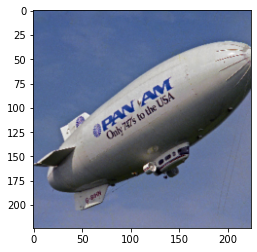

In [15]:
input_image = Image.open(DATA_DIR + '/405/5.jpeg')

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).numpy().astype(np.float32)

input = input_batch[0].transpose((1,2,0))
plt.imshow(input)

In [114]:
# res = calculate_IoU_score(input_batch[0], x_test_adv[0])

In [16]:
preds = classifier.predict(input_batch)
print(np.argmax(preds, axis=1))

accuracy = np.max(softmax_activation(preds), axis=1)
accuracy = round(accuracy[0], 2)
print("Accuracy on benign examples: {}%".format(accuracy * 100))

[405]
Accuracy on benign examples: 100.0%


### Attack 

In [17]:
# fgsm_attack = FastGradientMethod(estimator = classifier, eps=0.05)
# newton_attack = NewtonFool(classifier=classifier, max_iter=50, verbose=False)  
# cw_attack = CarliniL2Method(classifier=classifier, max_iter=2, learning_rate=0.05, verbose=True)
# attack_simba = SimBA(classifier=classifier, epsilon = 0.05, max_iter=5000) # .0025, 10K  
hopskipjump_attack = HopSkipJump(classifier=classifier, max_iter=20, verbose=True)

start = time.time()
x_test_adv = hopskipjump_attack.generate(x=input_batch)
print(time.time()-start) 

predictions = classifier.predict(x_test_adv)
print(np.argmax(predictions, axis=1))

# accuracy = np.max(predictions, axis=1)

accuracy = round(np.max(softmax_activation(predictions), axis=1)[0]*100,2)
print("Accuracy on adversarial test examples: {}%".format(accuracy))

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

113.5478618144989
[3]
Accuracy on adversarial test examples: 57.5%


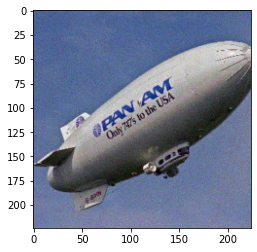

In [18]:
input = x_test_adv[0].transpose((1,2,0))
plt.imshow(input)

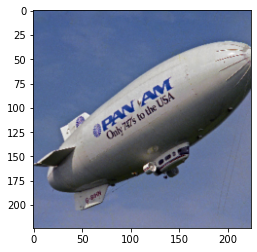

In [19]:
input = input_batch[0].transpose((1,2,0))
plt.imshow(input)

In [20]:
compare_images(input_batch[0].transpose(1,2,0), x_test_adv[0].transpose(1,2,0))

0.10912286482500422

In [23]:
criterion = nn.CrossEntropyLoss()

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model_densenet161,
    loss=criterion,
    input_shape=(3, 224, 224),
    nb_classes=1000,
    device_type='gpu'
) 

predictions = classifier.predict(x_test_adv)
print(np.argmax(predictions, axis=1))

accuracy = round(np.max(softmax_activation(predictions), axis=1)[0]*100,2)
print("Accuracy on adversarial test examples: {}%".format(accuracy))

[405]
Accuracy on adversarial test examples: 100.0%


In [21]:
# pip install grad-cam

In [24]:
from pytorch_grad_cam import GradCAM 
from pytorch_grad_cam.utils.image import show_cam_on_image 
from torchvision.models import densenet161, resnet18 

model = densenet161(pretrained=True)
# model = resnet18(pretrained=True)
model.eval()
target_layers = [model.features[-1]] 
# target_layers = [model.layer4[-1]] 

target_category = 405 

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True) 

In [29]:
grayscale_cam = cam(torch.tensor(input_batch), target_category=target_category) 
grayscale_cam = grayscale_cam[None, :]
visualization = show_cam_on_image(input_batch[0].transpose(1,2,0), grayscale_cam)

In [25]:
import cv2

In [26]:
def resize(img, new_size=(224, 224)):
    img = np.uint8(255 * img.transpose([1, 2, 0]))
    img = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)
    img = img.transpose([2, 0, 1])
    return np.float32(img / 255.)
def transform_mask(img, mask, new_size=(224, 224)):
    m1 = np.uint8(255 * cv2.resize(1 - mask[0], new_size, interpolation=cv2.INTER_LINEAR))
    m1 = cv2.applyColorMap(m1, cv2.COLORMAP_JET)
    m1 = np.float32(m1 / 255.).transpose([2, 0, 1])[::-1]
    m1 = (img + m1)
    m1 = m1 / m1.max()
    return m1
def plot(img, heatmap):
    m1 = np.uint8(255 * cv2.resize(1 - heatmap, (224, 224), interpolation=cv2.INTER_LINEAR))
    m1 = cv2.applyColorMap(m1, cv2.COLORMAP_JET)
    m1 = np.float32(m1 / 255.).transpose([2, 0, 1])[::-1]
    m1 = (img + m1)
    m1 = m1 / m1.max()
    # plt.imshow(m1.transpose((1,2,0)))
    # return np.float32(m1).transpose((1,2,0))
    return m1.transpose((1, 2, 0))

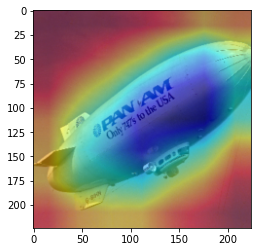

In [30]:
plt.imshow(plot(input_batch[0], grayscale_cam.squeeze()))

In [125]:
grayscale_cam.shape

(1, 1, 224, 224)

In [27]:
grayscale_cam = cam(torch.tensor(x_test_adv), target_category=149) 
grayscale_cam = grayscale_cam[None, :]
visualization = show_cam_on_image(x_test_adv[0].transpose(1,2,0), grayscale_cam)

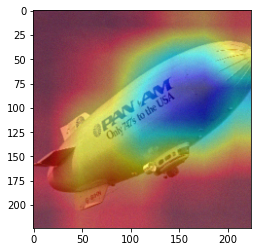

In [28]:
plt.imshow(plot(x_test_adv[0], grayscale_cam.squeeze()))

In [111]:
model 

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
vals = len(np.unique(img))
vals = 2 ** np.ceil(np.log2(vals))
noisy = np.random.poisson(img * vals) / float(vals)
return noisy.astype(np.uint8) 